In [1]:
import pandas as pd             # data package
import matplotlib.pyplot as plt # graphics 
import datetime as dt
import numpy as np
from census import Census # This is new...
from scipy.stats.mstats import gmean

import requests, io             # internet and input tools  
import zipfile as zf            # zip file tools 
import os  

#import weightedcalcs as wc
#import numpy as np

import pyarrow as pa
import pyarrow.parquet as pq

https://www.imf.org/external/np/sta/tegppi/ch20.pdf

This .pdf plug in the different chapters gives a good idea about stuff. 20 talks about elemetry indicies, so say do that at a low level, then when you aggregate do something like a tornqvist of fisher

I'm going to follow Broda and Weinstein (2006) https://web.stanford.edu/~klenow/Broda_and_Weinstein.pdf in setting things up.

The first question is level of aggregation and what a variety is. I'm going to do this at the HS4 level. What this means is then each HS10 product X country within the HS4 code is a variety. 

In [2]:
def make_expenditure_shares(df):
    
    df["S_gct"] = df["CON_VAL_MO"] / df["CON_VAL_MO"].sum()
    
    df["log_S_gct"] = np.nan
    
    df["log_S_gct"][df["CON_VAL_MO"]>0] = np.log( df["S_gct"][df["CON_VAL_MO"]>0] )
     
    return df

In [4]:
my_key = "&key=34e40301bda77077e24c859c6c6c0b721ad73fc7"
# This is my key. I'm nice and I have it posted. If you will be doing more with this
# please get your own key!

In [594]:
end_use = "hs?get=CON_VAL_MO,CTY_NAME,I_COMMODITY_SDESC,CON_QY1_MO,UNIT_QY1"

url = "https://api.census.gov/data/timeseries/intltrade/imports/" + end_use 
url = url + my_key + "&time==from+2013-01" + "&COMM_LVL=HS10" + "&I_COMMODITY=85*" + "&CTY_CODE=5700"

# This will grab all products that fall under the "non-alloyed unwrought aluminum"
# and will have the quantity values that all appear to be in Killograms

r = requests.get(url) 
    
print(r)
    
df = pd.DataFrame(r.json()[1:]) # This then converts it to a dataframe
    # Note that the first entry is the labels

df.columns = r.json()[0]

df.time = pd.to_datetime(df.time, format="%Y-%m")

df["CON_VAL_MO"] = df["CON_VAL_MO"].astype(float)

df["CON_QY1_MO"] = df["CON_QY1_MO"].astype(float)

df = df[df["CON_QY1_MO"] > 0]

df["price"] = df.CON_VAL_MO / df.CON_QY1_MO

<Response [200]>


In [595]:
df.set_index(["time", "I_COMMODITY"], inplace = True)

df.head(30)

CON_VAL_MO CTY_NAME  \
time       I_COMMODITY                        
2013-01-01 8525601010    1172504.0    CHINA   
           8528714000   13138842.0    CHINA   
           8525805050   41350792.0    CHINA   
           8527120000      64346.0    CHINA   
           8527991500    2102574.0    CHINA   
           8528592300    1415448.0    CHINA   
           8528713000     189387.0    CHINA   
           8527195025    1397033.0    CHINA   
           8528724800       3122.0    CHINA   
           8528726200     265482.0    CHINA   
           8517180050   17118665.0    CHINA   
           8519302000    1036989.0    CHINA   
           8518402000   26459384.0    CHINA   
           8519814050   21672699.0    CHINA   
           8523492020    2266933.0    CHINA   
           8527132015     816403.0    CHINA   
           8527136040    6961704.0    CHINA   
           8527994000     164970.0    CHINA   
           8528592500   20968695.0    CHINA   
           8517180010    5366323.0    CHINA   
           8518210000   26979358.0    CHINA   
           8523493000     171020.0    CHINA   
           8525601030    4637710.0    CHINA   
           8527136080   23870633.0    CHINA   
           8527191000    2558168.0    CHINA   
           8528593100   51824185.0    CHINA   
           8528593310      30572.0    CHINA   
           8528720800      12365.0    CHINA   
           8528721200      60876.0    CHINA   
           8528722400      58886.0    CHINA   

                                                        I_COMMODITY_SDESC  \
time       I_COMMODITY                                                      
2013-01-01 8525601010              RADIO TRANSCIEVERS, CITIZENS BAND (CB)   
           8528714000     TV RECPT APPARATUS, COLOR, NO VID DISPAY, NESOI   
           8525805050   STILL IMAGE VIDEO CAMERA,VDEO CAMERA RECORDR,N...   
           8527120000                  POCKET-SIZE RADIO CASSETTE PLAYERS   
           8527991500                               RADIO RECEIVERS NESOI   
           8528592300                       VIDEO MON,CLR,FLAT PNEL SCR,W   
           8528713000                  TV RECP; COLOR, PC ASSEM, W/ TUNER   
           8527195025            RADIOBROADCAST RECEIVERS, BATTERY, NESOI   
           8528724800    TV RECP,COLOR,HD,NON-PROJ,W/CATH-RAY TUBE, NESOI   
           8528726200                              TV RECP,COL,FLAT PAN S   
           8517180050                          SINGLE LINE TELEPHONE SETS   
           8519302000                                   TURNTABLES, NESOI   
           8518402000          AUDIO FREQUENCY ELECTRIC AMPLIFIERS, NESOI   
           8519814050   SOUND RECORD APP MGNT/OPTCL/SEMICNDCTR MEDIA N...   
           8523492020   LASER DISCS,NOT FOR REPRODUCING SOUND/IMAGE, N...   
           8527132015            RADIO-TAPE RECORD COMBINTN, BTY, CASSTTE   
           8527136040                                  RADIOBROADCAST REC   
           8527994000           RECEPTION APPARATUS FOR RADIOBROADCASTING   
           8528592500   VIDEO MONITORS, CLR, FLAT PNEL SCR,LT= 34.29CM...   
           8517180010                                         VIDEOPHONES   
           8518210000    SINGLE LOUDSPEAKERS, MOUNTED IN THEIR ENCLOSURES   
           8523493000   RECORDED OPTICAL MEDIA, FOR REPRODUCING SOUND ...   
           8525601030                        RADIO TRANSCIEVERS,HAND-HELD   
           8527136080    RADIOBROADCAST RECEIVER COMBINATIONS, BTY, NESOI   
           8527191000                                  RADIO RECEIVERS,BA   
           8528593100                                LCD VID MNTR,CLR,FLT   
           8528593310   PLASMA VID MNTR,CLR,FLT PNL SCR,GT 34.29 CM, N...   
           8528720800         TV RECV,INCOMP ASSMB,COLOR,NO CRT, FLAT PAN   
           8528721200                         TV RECV,COLOR,REC/REP,NON-H   
           8528722400   TV RECV,NON-HD,COL,SING PT TUB,NON-PRO, GT 34....   

                        CON_QY1_MO UNIT_QY1 COMM_LVL C

In [607]:
def common_set_price(df, dfall):
    
    outdf = pd.DataFrame()
    
    if df.index.get_level_values(0)[0].year == 2013:
        
        log_pt = np.nan
        
        log_pt1 = np.nan
        
        ngoods = np.nan
        
        outdf["delta_log_pt"] = [log_pt - log_pt1]
        
        outdf["ngoods"] = [ngoods]
        
        return outdf
    
    footime = df.index.get_level_values(0)[0]
    # gets the current time
        
    footime2 = dt.datetime(2013, footime.month, 1)
    # a year back
    
    bar = dfall.loc[footime2]
    
    common_set_index = bar.index.intersection(df.index.get_level_values(1))
    
    cxpt = df.loc[(footime, common_set_index),:].CON_VAL_MO.to_numpy()
    
    cxpt1 = dfall.loc[(footime2, common_set_index),:].CON_VAL_MO.to_numpy()
    
    xpt = df.loc[footime].CON_VAL_MO.to_numpy()
    
    xpt1 = dfall.loc[footime2].CON_VAL_MO.to_numpy()

    pt = df.loc[(footime, common_set_index),:].price.to_numpy()
    
    pt1 = dfall.loc[(footime2, common_set_index),:].price.to_numpy()
    
    #####################################################################################
    
    price_index, wt = sato_varita(pt, pt1, cxpt, cxpt1)
    
    lambda_t, lambda_t1, ratio_lambda = feenstra_adjustment(cxpt,cxpt1,xpt,xpt1)
        
    #####################################################################################    
    sigma = 4
    
    ngoods= df.loc[(footime, common_set_index),:].price.count()
    
    outdf["delta_log_pt"] = [price_index]
    
    outdf["delta_log_pt_adj"] = [np.exp(price_index + (1/(sigma - 1)) * np.log(ratio_lambda))]
    
    outdf["ngoods"] = [ngoods]
    
    outdf["feenstra_adj"] = [ratio_lambda]
                
    return outdf

In [589]:
def feenstra_adjustment(cxpt,cxpt1,xpt,xpt1):
    
    lambda_t = cxpt.sum() / xpt.sum()
    # this is equation 11 in Broda Weinstein
    # take sum of common set / sum of all
    
    lambda_t1 = cxpt1.sum() / xpt1.sum()
    
    ratio_lambda = lambda_t / lambda_t1
    
    return lambda_t, lambda_t1, ratio_lambda

In [590]:
def sato_varita(pt,pt1,xpt,xpt1):
    
    if xpt1.size != xpt.size:
        
        print("common set not common")
        
        return np.nan
    
    st = xpt / xpt.sum() # these are shares over common set
    
    st1 = xpt1 / xpt1.sum()
    
    log_st = np.log(st)
    
    log_st1 = np.log(st1)
    
    wtnum = ((st - st1) / (log_st - log_st1)) 
    
    wtden = wtnum.sum()
    
    wt = wtnum / wtden # equation 10 in Broda Weinstain
    
    price_index = (wt * (np.log(pt) - np.log(pt1))).sum()
    
    return price_index, wt

In [608]:
grp = df.groupby(["time"])

ptest = grp.apply(lambda x: common_set_price(x, df))

ptest.reset_index(inplace = True)

ptest.drop(["level_1"], inplace = True, axis = 1)

ptest.set_index(["time"], inplace = True)

<AxesSubplot:xlabel='time'>

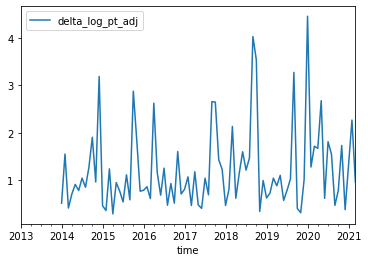

In [609]:
ptest[["delta_log_pt_adj"]].plot()

<AxesSubplot:xlabel='time'>

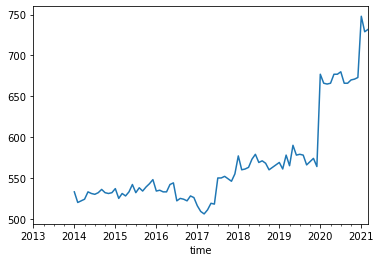

In [599]:
ptest.ngoods.plot()

In [610]:
ptest.loc[:"2018-6"].mean()

delta_log_pt         -0.066223
ngoods              512.537037
delta_log_pt_adj      1.096425
feenstra_adj          0.979741
dtype: float64

In [611]:
ptest.loc["2018-6":].mean()

delta_log_pt          0.212035
ngoods              474.676471
delta_log_pt_adj      1.433878
feenstra_adj          0.777910
dtype: float64